# Bloque 5 Neurología: Práctica 6 - Machine Learning 

En esta práctica, vamos a sumergirnos en el fascinante mundo de las Máquinas de Vectores de Soporte (SVM). Comenzaremos programando una SVM desde cero, lo que nos permitirá entender a fondo los fundamentos y la matemática detrás de este poderoso algoritmo de clasificación.

## Objetivos de la Práctica

1. **Comprender los conceptos básicos de las SVM**: Exploraremos qué es una SVM, cómo funciona y en qué situaciones es útil.
2. **Programar una SVM desde cero**: Implementaremos una SVM utilizando Python, sin recurrir a bibliotecas externas, para afianzar nuestro entendimiento de su funcionamiento interno.
3. **Explorar implementaciones existentes**: Una vez que tengamos nuestra SVM básica, compararemos su rendimiento con implementaciones de bibliotecas populares como `scikit-learn`.
4. **Aplicar SVM a ejemplos prácticos**: Utilizaremos datasets reales para ver cómo las SVM pueden resolver problemas de clasificación en el mundo real.




## Formulación
$$
\begin{align*}
    \min_{\bm{w},\beta} \quad & \frac{1}{2} ||\bm{w}||^2 + C\sum_{i=1}^N \xi_i \\
    \text{s.a:} \quad  & y_i(\bm{x}^T \bm{w} + \beta) \geq 1 - \xi_i \quad \forall i \in \{1, \ldots, N\} \\
    & \xi_i \geq 0
\end{align*}
$$



## Método de optimización

Como dijimos, una vez obtenido el problema dual, es necesario resolverlo. Al ser un problema de optimización convexo, podemos utilizar varios métodos, en esta práctica utilizaremos la implementación propuesta en `cvxpy` (pip install cvxpy)

## Predicción y Cálculos Posteriores

Para la predicción la realizaremos obteniendo el signo del resultado la ecuación $$w\cdot x + b$$
Para calcular los $\alpha_i$ buscaremos aquellas posiciones que cumplan $$w\cdot x + b=0$$ 
Dado que nos encontramos ante un clasifciador lineal, podremos obtener la importancia de las variables viendo el valor del vector de pesos.

### Ensamblamos todas las partes en una clase y probamos con un ejemplo sencillo

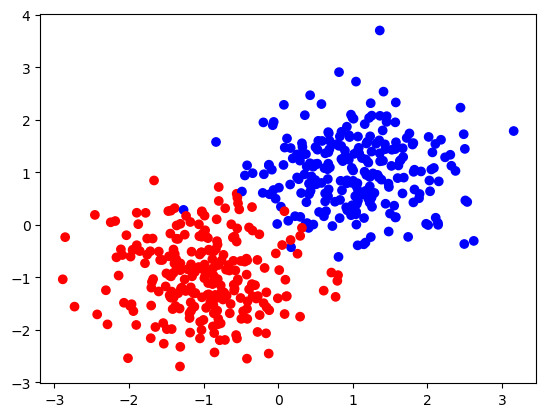

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


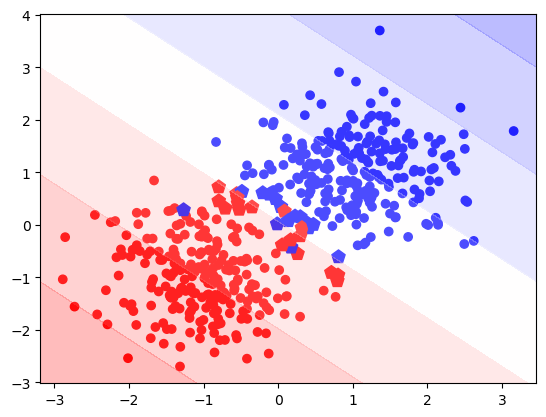

3.4019572292633047


In [16]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import cvxpy as cp


class SVM:
    def __init__(self, C=1.0):
        # Inicializa la SVM con el parámetro de regularización C
        self.C = C
        self.w = 0
        self.b = 0

    def miKernel(self, x):
        # Define el kernel lineal con una pequeña perturbación para evitar problemas numéricos
        K = x @ x.T + np.identity(len(x)) * 1e-12
        return K

    def fit(self, X, Y):
        # Obtiene el número de características y muestras
        numero_de_caracteristicas = X.shape[1]
        numero_de_muestras = X.shape[0]

        # Calcula la matriz del kernel
        kVal = self.miKernel(X)

        # Define las variables de optimización
        b = cp.Variable()
        alpha = cp.Variable(numero_de_muestras)
        xi = cp.Variable(numero_de_muestras)
        mui = cp.Variable(numero_de_muestras)
        gamma = cp.multiply(alpha, Y)

        # Define el parámetro del kernel para cvxpy
        K = cp.Parameter(shape=kVal.shape, PSD=True, value=kVal)

        # Define la función objetivo (dual)
        LD = cp.sum(alpha) - 1 / 2 * cp.quad_form(gamma, K)
        objective = cp.Maximize(LD)

        # Define las restricciones
        constraints = [alpha >= 0, alpha <= self.C]
        constraints += [cp.sum(cp.multiply(alpha, Y)) == 0]
        constraints += [
            Y[i] * (cp.sum(cp.multiply(cp.multiply(alpha, Y), K[:, i])) + b)
            - (1 - xi[i])
            >= 0
            for i in range(numero_de_muestras)
        ]
        constraints += [xi >= 0]

        # Define el problema de optimización
        problem = cp.Problem(objective, constraints)

        # Resuelve el problema de optimización
        problem.solve()

        # Calcula los parámetros w y b
        self.w = np.multiply(Y, alpha.value).T @ X
        S = (alpha.value > 1e-4).flatten()
        self.b = np.mean(Y[S] - X[S, :] @ self.w)
        self.xi = np.max(xi.value)

        # Guarda los valores de alpha y los vectores de soporte
        self.alpha = alpha.value[S]
        self.VS = X[S, :]
        self.ys = Y[S]
        return self.alpha

    def predice(self, X):
        # Predice las etiquetas para los datos de entrada X
        K = self.VS @ X.T
        aux = self.ys * self.alpha
        prediccion = aux @ K + self.b
        return prediccion


# Genera algunos datos de ejemplo
X, y = make_blobs(
    n_samples=500, centers=[[1, 1], [-1, -1]], cluster_std=0.7, random_state=42
)
y = np.where(y == 0, -1, 1)  # Convierte las etiquetas a -1 y 1

# Muestra los datos generados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.show()

# Inicializa y entrena la SVM
svm = SVM(C=1)
svm.fit(X, y)


# Función para graficar la frontera de decisión
def plot_decision_boundary(X, y, model):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
    )
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    Z = model.predice(xy).reshape(xx.shape)
    VS = model.VS
    ys = model.ys
    plt.scatter(VS[:, 0], VS[:, 1], c=ys, marker="p", cmap="bwr", s=100)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
    plt.show()


# Grafica la frontera de decisión
plot_decision_boundary(X, y, svm)
print(svm.xi)

### Incluye los cambios necesarios para que el kernel sea gaussiano

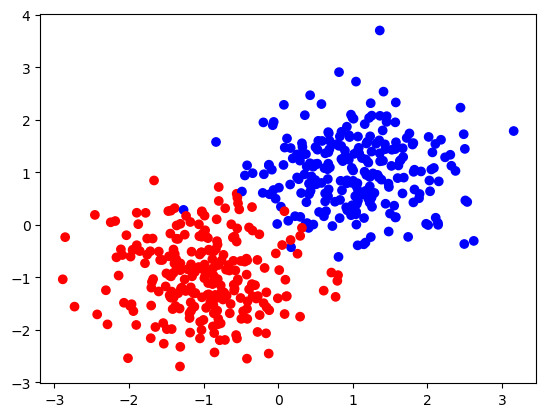

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


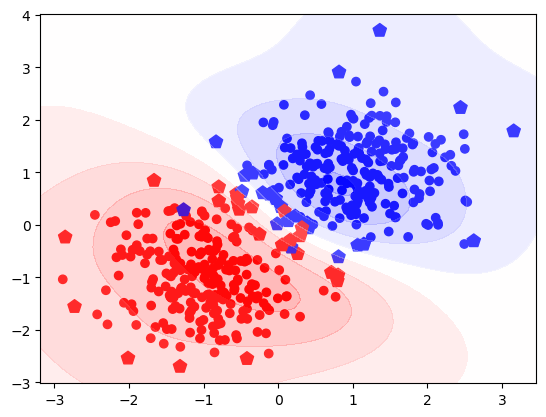

3.4831438421110765


In [17]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import cvxpy as cp


class SVM:
    def __init__(self, C=1.0, sigma=1.0):
        # Inicializa la SVM con el parámetro de regularización C y el parámetro del kernel Gaussiano sigma
        self.C = C
        self.sigma = sigma
        self.w = None
        self.b = None

    def miKernel(self, X1, X2=None):
        # Define el kernel Gaussiano (RBF).
        #Si X2 no se proporciona, se calcula el kernel sobre sí mismo (matriz cuadrada).
        if X2 is None:
            X2 = X1
        pairwise_sq_dists = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        K = np.exp(-pairwise_sq_dists / (2 * self.sigma**2))
        return K

    def fit(self, X, Y):
        numero_de_muestras = X.shape[0]

        # Calcula la matriz del kernel
        kVal = self.miKernel(X)

        # Define las variables de optimización
        b = cp.Variable()
        alpha = cp.Variable(numero_de_muestras)
        xi = cp.Variable(numero_de_muestras)

        gamma = cp.multiply(alpha, Y)

        # Define el parámetro del kernel para cvxpy
        K = cp.Parameter(shape=kVal.shape, PSD=True, value=kVal)

        # Define la función objetivo (dual)
        LD = cp.sum(alpha) - 1 / 2 * cp.quad_form(gamma, K)
        objective = cp.Maximize(LD)

        # Define las restricciones
        constraints = [alpha >= 0, alpha <= self.C]
        constraints += [cp.sum(cp.multiply(alpha, Y)) == 0]
        constraints += [
            Y[i] * (cp.sum(cp.multiply(cp.multiply(alpha, Y), K[:, i])) + b)
            - (1 - xi[i])
            >= 0
            for i in range(numero_de_muestras)
        ]
        constraints += [xi >= 0]

        # Define el problema de optimización
        problem = cp.Problem(objective, constraints)

        # Resuelve el problema de optimización
        problem.solve()

        # Guarda los valores de alpha y los vectores de soporte
        S = (alpha.value > 1e-4).flatten()
        self.alpha = alpha.value[S]
        self.VS = X[S, :]
        self.ys = Y[S]

        # Calcula b usando los vectores de soporte
        K_SV = self.miKernel(self.VS, self.VS)
        self.b = np.mean(self.ys - np.sum(K_SV * (self.alpha * self.ys)[:, None], axis=0))

        self.xi = np.max(xi.value)

    def predice(self, X):
        # Predice las etiquetas para los datos de entrada X usando el kernel Gaussiano.
        K = self.miKernel(self.VS, X)
        prediccion = np.sum((self.alpha * self.ys)[:, None] * K, axis=0) + self.b
        return prediccion


# Genera algunos datos de ejemplo
X, y = make_blobs(n_samples=500, centers=[[1, 1], [-1, -1]], cluster_std=0.7, random_state=42)
y = np.where(y == 0, -1, 1)  # Convierte las etiquetas a -1 y 1

# Muestra los datos generados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.show()

# Inicializa y entrena la SVM con kernel Gaussiano
svm = SVM(C=1, sigma=1.0)  # Ajusta sigma según la dispersión de los datos
svm.fit(X, y)


# Función para graficar la frontera de decisión
def plot_decision_boundary(X, y, model):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
    )
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    Z = model.predice(xy).reshape(xx.shape)
    VS = model.VS
    ys = model.ys
    plt.scatter(VS[:, 0], VS[:, 1], c=ys, marker="p", cmap="bwr", s=100)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
    plt.show()


# Grafica la frontera de decisión
plot_decision_boundary(X, y, svm)
print(svm.xi)

### Ejemplo con las funciones predefinidas de python

Este ejemplo muestra cómo diferentes núcleos en un :class:`~sklearn.svm.SVC` (Clasificador de Vectores de Soporte) influyen en los límites de clasificación en un problema de clasificación binaria y bidimensional.

Los SVCs buscan encontrar un hiperplano que separe efectivamente las clases en sus datos de entrenamiento maximizando el margen entre los puntos de datos más externos de cada clase. Esto se logra encontrando el mejor vector de peso $w$ que define el hiperplano de decisión y minimiza la suma de las pérdidas para las muestras mal clasificadas, según lo medido por la función `~sklearn.metrics.hinge_loss`. Por defecto, se aplica regularización con el parámetro $C=1$, lo que permite un cierto grado de tolerancia a la mala clasificación.

Si los datos no son linealmente separables en el espacio de características original, se puede establecer un parámetro de núcleo no lineal. Dependiendo del núcleo, el proceso implica agregar nuevas características o transformar las existentes para enriquecer y potencialmente agregar significado a los datos. Cuando se establece un núcleo distinto de `"linear"`, el SVC aplica el truco del núcleo, que calcula la similitud entre pares de puntos de datos utilizando la función de núcleo sin transformar explícitamente todo el conjunto de datos. El truco del núcleo supera la transformación de matriz necesaria considerando solo las relaciones entre todos los pares de puntos de datos. La función de núcleo mapea dos vectores (cada par de observaciones) a su similitud usando su producto punto.

El hiperplano se puede calcular utilizando la función de núcleo como si el conjunto de datos estuviera representado en un espacio de mayor dimensión. Usar una función de núcleo en lugar de una transformación de matriz explícita mejora el rendimiento, ya que la función de núcleo tiene una complejidad temporal de $O({n}^2)$, mientras que la transformación de matriz escala según la transformación específica que se aplique.

En este ejemplo, comparamos los tipos de núcleo más comunes de las Máquinas de Vectores de Soporte: el núcleo lineal (`"linear"`), el núcleo polinómico (`"poly"`), el núcleo de función de base radial (`"rbf"`) y el núcleo sigmoide (`"sigmoid"`).



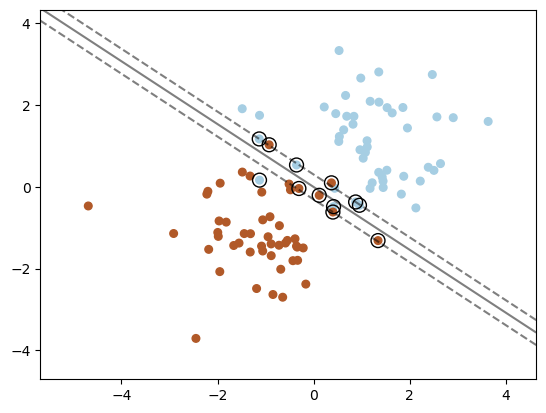

In [18]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# we create 40 separable points
X, y = make_blobs(n_samples=100, centers=[[1, 1], [-1, -1]], random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

### Prueba con diferentes nucleos

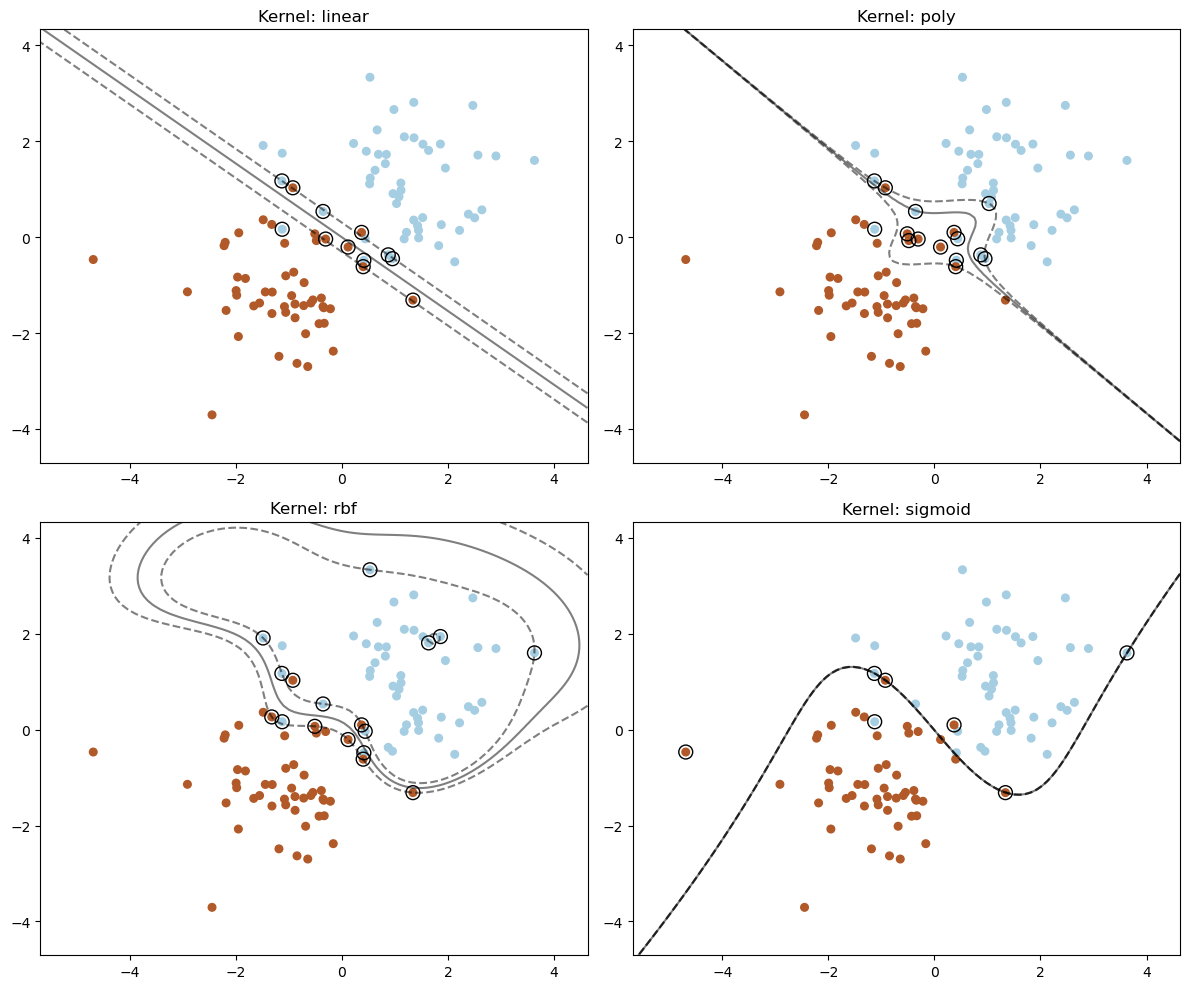

In [19]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# Generamos 100 puntos de dos clases separables
X, y = make_blobs(n_samples=100, centers=[[1, 1], [-1, -1]], random_state=6)

# Definimos los diferentes kernels a probar
kernels = ["linear", "poly", "rbf", "sigmoid"]

# Crear una figura con subgráficos para cada kernel
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, kernel in zip(axes.ravel(), kernels):
    # Entrenamos el modelo con el kernel actual
    clf = svm.SVC(kernel=kernel, C=1000)
    clf.fit(X, y)

    # Dibujar los puntos de datos
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # Graficar la frontera de decisión
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
        ax=ax,
    )

    # Dibujar los vectores de soporte
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )

    ax.set_title(f"Kernel: {kernel}")

plt.tight_layout()
plt.show()

## Clasificaremos EEG- Eye State dataset

Una vez realziado toda la práctica, es hora de mostar tus habilidades clasificando el dataset de vinos.
Estos datos son el resultado de un análisis químico de vinos cultivados en la misma región de Italia, pero derivados de tres cultivares diferentes. El análisis determinó las cantidades de 13 componentes encontrados en cada uno de los tres tipos de vinos.

Alcohol

Ácido málico

Ceniza

Alcalinidad de la ceniza

Magnesio

Fenoles totales

Flavonoides

Fenoles no flavonoides

Proantocianidinas

Intensidad del color

Matiz

OD280/OD315 de vinos diluidos

Prolina

In [20]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Cargar el conjunto de datos de vinos
data = load_wine()
X = data.data
y = data.target

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# Normalizar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar un clasificador de Máquina de Vectores de Soporte (SVM)
svm_classifier = SVC(kernel="rbf", random_state=42)                 # Utiliza solo kernel rbf
svm_classifier.fit(X_train_scaled, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = svm_classifier.predict(X_test_scaled)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del clasificador SVM: {accuracy:.2f}")

Precisión del clasificador SVM: 0.98


### Probar con diferentes núcleos

    Kernel  Accuracy
0   linear  0.988764
1     poly  0.865169
2      rbf  0.977528
3  sigmoid  0.977528


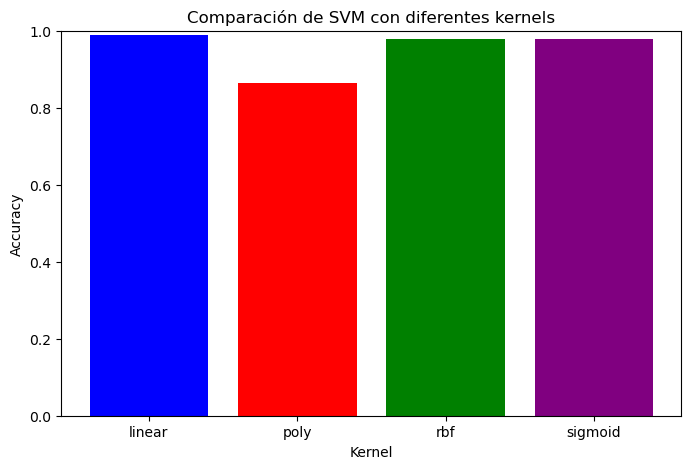

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el conjunto de datos de vinos
data = load_wine()
X = data.data
y = data.target

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# Normalizar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista de kernels a evaluar
kernels = ["linear", "poly", "rbf", "sigmoid"]

# Diccionario para almacenar las precisiones
kernel_accuracies = {}

# Probar diferentes kernels
for kernel in kernels:
    # Entrenar un clasificador de Máquina de Vectores de Soporte (SVM)
    svm_classifier = SVC(kernel=kernel, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)

    # Predecir las etiquetas para el conjunto de prueba
    y_pred = svm_classifier.predict(X_test_scaled)

    # Calcular la precisión del clasificador
    accuracy = accuracy_score(y_test, y_pred)
    kernel_accuracies[kernel] = accuracy

# Convertir resultados en DataFrame
results_df = pd.DataFrame(list(kernel_accuracies.items()), columns=["Kernel", "Accuracy"])

# Mostrar los resultados
print(results_df)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.bar(results_df["Kernel"], results_df["Accuracy"], color=['blue', 'red', 'green', 'purple'])
plt.xlabel("Kernel")
plt.ylabel("Accuracy")
plt.title("Comparación de SVM con diferentes kernels")
plt.ylim(0, 1)
plt.show()

Las características con valores más bajos a decidir, son los parámetros más irrelevantes a comparar. Debido a que son los que menor valor dan a las decisiones que se toman en las fronteras, y que seguramente cometan más errores que los valores más grandes y con mayor margen de decisión.